# Hernquist distribution - stability analysis
**RACHELE GUIDETTI**

In this notebook I present an analysis aimed to study the stability of a Hernquist distribution. First, I will initialize the distribution, then I will compute its evolution in time using the treecode by Joshua E. Barnes and lastly I will perform the analysis to check the stability of the distribution. 

In the notebook "Hernquist_perturber" I will add a perturber to the distribution in order to study the evolution of the system under this new condition.

--- 
<img src="Hernquist.gif" align="right" width="600px"/>


This notebook is structured as follows:
1. **Distribution initialization**
- Variables declaration
- Positions sampling (in spherical coordinates then converted in cartesian coordinates)
- Velocities sampling (using the MC rejection method)
- Creation of the input file and computation of the parameters to run the simulation, such as the dynamical time

  
2. **Analysis**
- Data reading from the output files
- Computation of the Lagrangian radii
- Radii distribution check
- Analysis of the energies


3. **Physical Units**

    Conversion of the key variables of the system from internal units (IU) to physical units (PU)



In [1]:
import numpy as np
import scipy
import math
import random
import pandas as pd
from matplotlib import animation
import matplotlib as mpl
import seaborn as sns


from matplotlib.animation import FuncAnimation
import os
import time
from scipy.stats import uniform
from scipy.integrate import quad
import tqdm as tqdm
from tqdm import tqdm
from astropy.visualization.hist import hist as fancyhist

from matplotlib import pyplot as plt
from matplotlib import colormaps
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Hernquist Distribution
**(source: J. Binney and S. Tremaine, "Galactic dynamics")**

The density of a Hernquist distribution is given by:


$
$
$$
    \rho(r) = \frac{\rho_0}{(r/Rs)(1+r/Rs)^4}.\tag{1}
$$

where $Rs$ is the scale radius.


The mass interior to a radius _r_ is:


$$
    M(r) = \int_0^r \rho(r) 4 \pi r^2 dr = \dots = 4  \pi \rho_0 Rs^3 \frac{(r/Rs)^2}{2(1 + \frac{r}{Rs})^2}  \tag{2}.
$$
From this definition, we can define the total mass of the distribution and the initial density:


$$
    M_{tot} = 2 \pi \rho_0 R_s^3 \quad \longrightarrow \quad \rho_0 = \frac{M_{tot}}{2 \pi R_s  \tag{3}^3}.
$$


In order to initialize the positions of the particles in spherical coordinates we need _r_, _$\theta$_ and _$\phi$_.

Having the mass and the total mass of the system, it is possible to compute the cumulative distribution function for _r_:


$$
    P(r) = \frac{M(r)}{M_{tot}} = \frac{r^2}{(Rs + r)^2} \tag{4} .
$$

Inverting this equation, we can find the inverse cumulative distribution function for _r_:


$$
    r(P) = \frac{\sqrt{P} Rs}{1 - \sqrt{P}} \tag{5}.
$$

The distribution function for _$\theta$_ is:
$$
    P(\theta) = \frac{1}{2} \left( 1 - \cos\theta \right) \tag{6},
$$

from which we recover
:
$$
    \theta = arccos(1 - 2 P(\theta) ) \tag{7}.
$$

Lastly, the distribution function for _$\phi$_ is:


$$
    P(\phi) = \frac{1}{2 \pi} \tag{8}.
$$
_$\phi$_ has a uniform distribution between $0$ and $2\pi$.

# 1. Distribution initializazion

### Variables declaration
The current simulation has been run with:
- 10 000 particles
- total mass $M=1$
- scale radius $Rs = 1$

In [2]:
N  = 10000 # number of particles
M  = 1     # total mass
m  = M/N   # mass of the single particle
Rs = 1     # scale radius


# initial density (equation 3)
rho_0 = M / (2 * np.pi * (Rs)**3)

### Density Profile

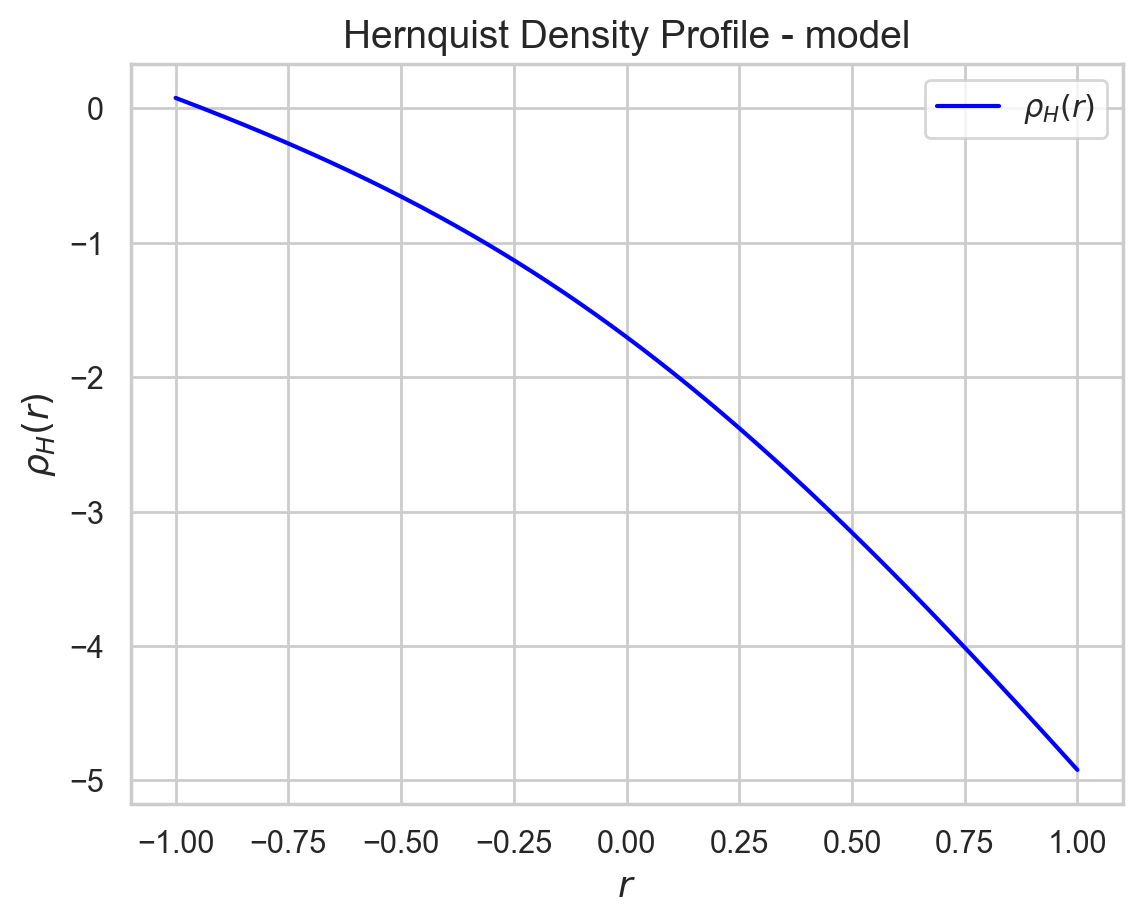

In [3]:
# equation 1
def H_profile(r, Rs, rho_0):
    return (rho_0 * (Rs**4)) / (r * ((r + Rs)**3))

########################################################à

sns.set(style="whitegrid")

raggi = np.linspace(0.1, 10*Rs, N)
rho_H = H_profile(raggi, Rs, rho_0)

plt.plot(np.log10(raggi), np.log10(rho_H), color='blue', label=r'$\rho_H(r)$')
plt.title('Hernquist Density Profile - model', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.ylabel(r'$\rho_H(r)$', fontsize=13)
plt.legend()

### Positions Sampling

In [4]:
# equation 5
def inv_cumulative(Rs, N):
    c = np.random.uniform(0.0001, 0.9999, size=N)
    return np.sqrt(c)*Rs / (1-np.sqrt(c))

In [5]:
# particles radius
radii = inv_cumulative(Rs, N)

# theta - equation 7
cdf_theta = uniform.rvs(0, 1, size=N)  
theta = np.arccos(1 - 2 * cdf_theta)

# phi - equation 9
phi = uniform.rvs(0, 2 * np.pi, size=N)

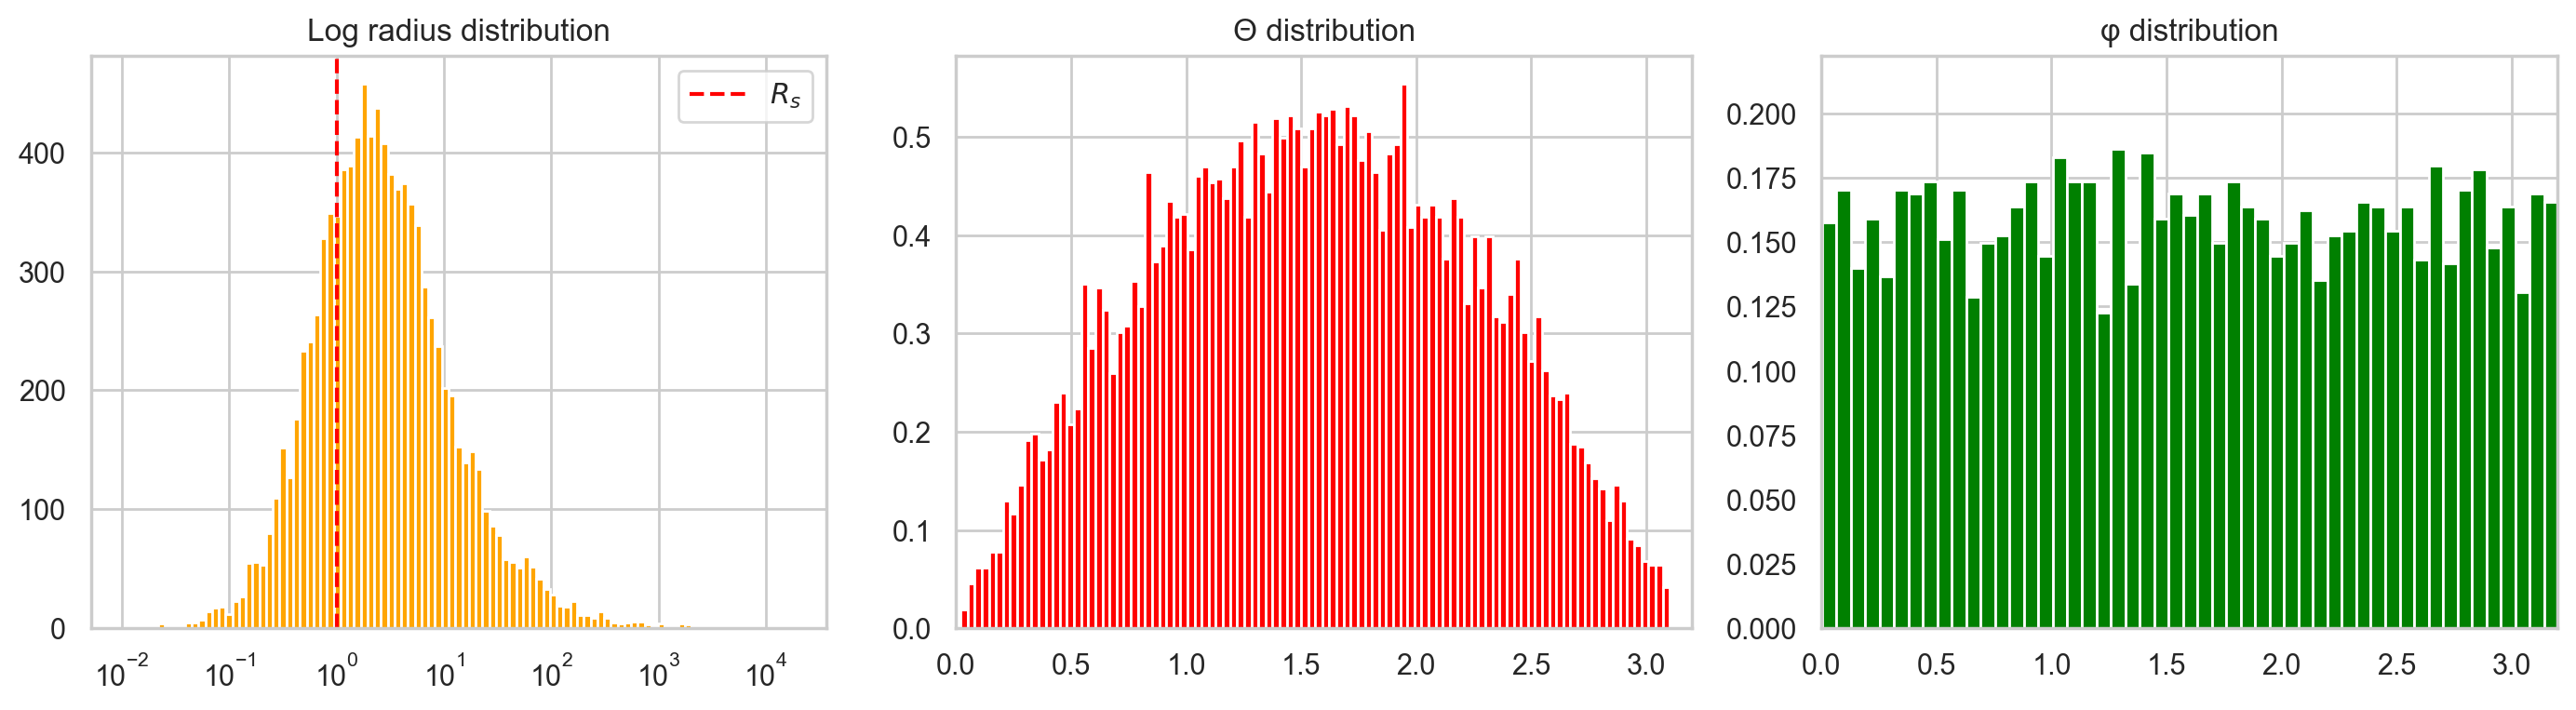

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].hist(radii, bins=np.logspace(np.log10(np.min(radii)), np.log10(np.max(radii)), 100), color='orange')
axes[0].axvline(x=Rs, linestyle='--', color='red', label=r'$R_s$')
axes[0].set_title('Log radius distribution')
axes[0].set_xscale('log')
axes[0].legend()

axes[1].hist(theta, bins=100, density=True, color='red')
axes[1].set_title("Θ distribution")
axes[1].set_xlim(0,3.2)

axes[2].hist(phi, bins=100, density=True, color='green')
axes[2].set_title("φ distribution")
axes[2].set_xlim(0,3.2)

plt.tight_layout()


I run a little test to check if the distribution of the radii is correct: I calculate the radius containing a certain percentage of particles (in this case 75%) and I compare this value with the expected radius, which is given by equation 5 substituting P with 0.75.

In [7]:
def calculate_radius(r, percentage):
    # Calculation of the radius containing a certain percentage of particles.
    
    sorted_r = np.sort(r)
    
    index = int(len(sorted_r) * percentage / 100)
    radius = sorted_r[index]
    
    return radius

##################################################################################à

percentage = 75  

radius = calculate_radius(radii, percentage)
print(f"Radius within which {percentage}% of the particles lie: {radius}")
print("Expected radius : ", np.sqrt(0.75)*Rs / (1-np.sqrt(0.75)))

Radius within which 75% of the particles lie: 6.394746462903212
Expected radius :  6.464101615137752


As we can see, the radius containing 75% of the particles is very similar to the theoretical radius.

### Cartesian coordinates
I convert the spherical coordinates into cartesian coordinates:
$$
    x = r sin(\theta) cos(\phi) \quad \quad 
    y = r sin(\theta) cos(\phi) \quad \quad 
    z = r cos(\theta) .
    $$

In [8]:
x = radii * np.sin(theta) * np.cos(phi)
y = radii * np.sin(theta) * np.sin(phi)
z = radii * np.cos(theta)

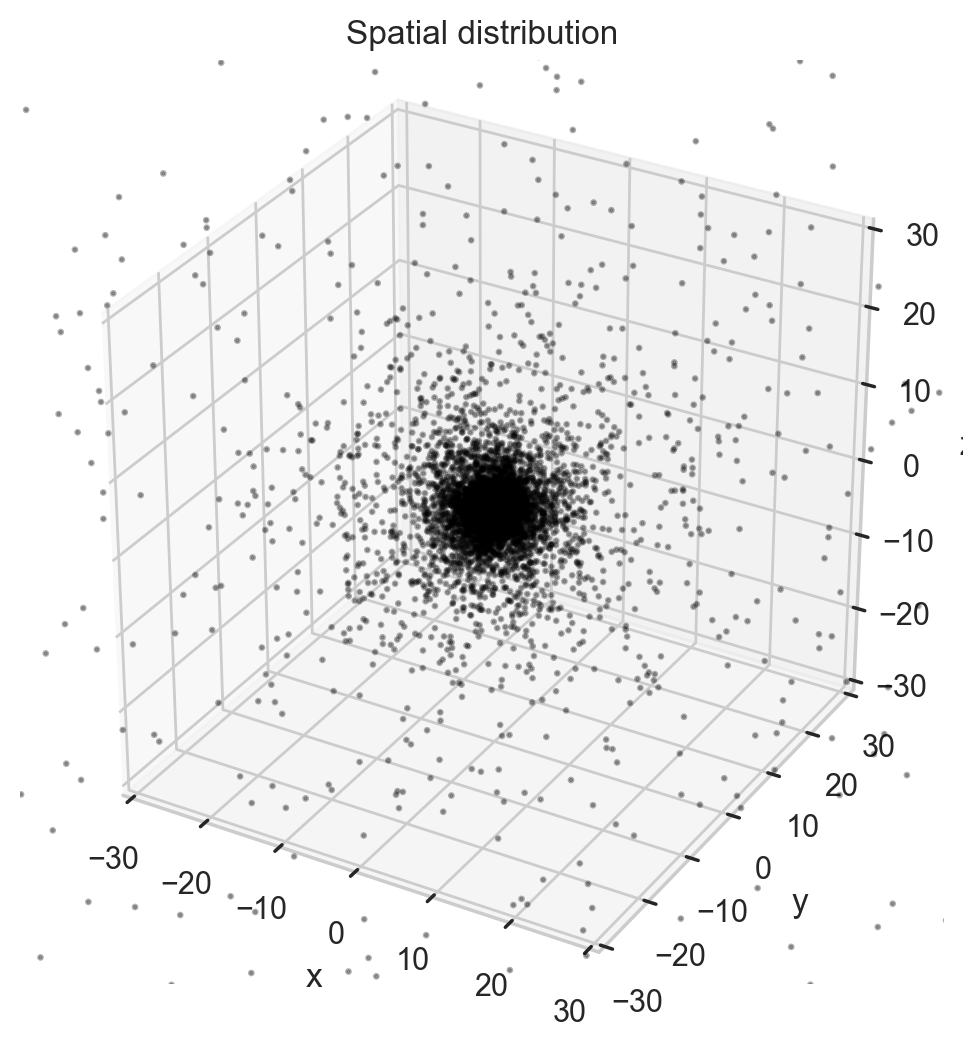

In [9]:
# spatial distribution - 3D
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, c = 'black', s=2, alpha = 0.3)

ax.set_box_aspect([1,1,1])
#ax.set_aspect('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_zlim(-30, 30)
ax.set_title("Spatial distribution")
ax.set_box_aspect([1,1,1])

plt.show();

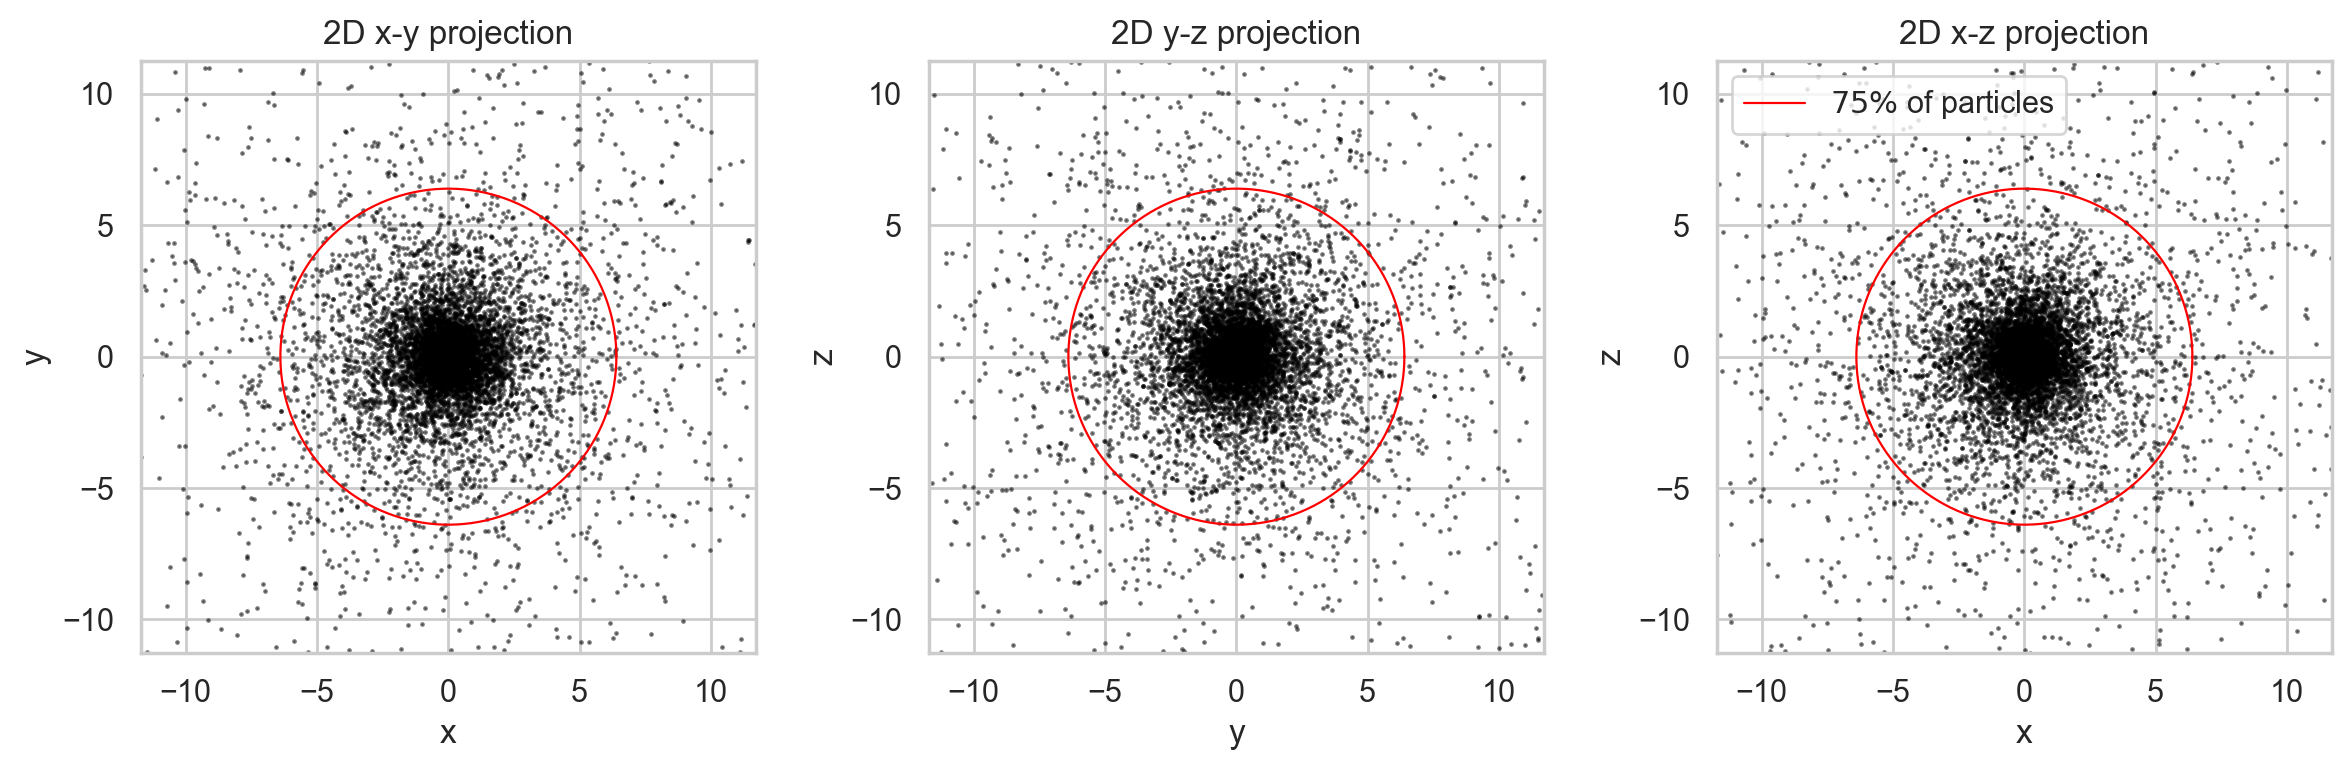

In [10]:
# spatial distribution - 2D

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Projection on x-y plane
theta = np.linspace(0, 2 * np.pi, 150)
a = radius * np.cos( theta )
c = radius * np.sin( theta )
axes[0].scatter(x, y, c='black', s=0.5, alpha=0.5)
axes[0].plot(a, c, c='red', linewidth=0.8, label=r'$75\%$ of particles')
axes[0].axis('equal')
axes[0].set_xlim(-10, 10)
axes[0].set_ylim(-10, 10)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('2D x-y projection')

# Projection on y-z plane
axes[1].scatter(y, z, c='black', s=0.5, alpha=0.5)
axes[1].plot(a, c, c='red', linewidth=0.8, label=r'$75\%$ of particles')
axes[1].axis('equal')
axes[1].set_xlim(-10, 10)
axes[1].set_ylim(-10, 10)
axes[1].set_xlabel('y')
axes[1].set_ylabel('z')
axes[1].set_title('2D y-z projection')


# Projection on x-z plane
axes[2].scatter(x, z, c='black', s=0.5, alpha=0.5)
axes[2].plot(a, c, c='red', linewidth=0.8, label=r'$75\%$ of particles')
axes[2].axis('equal')
axes[2].set_xlim(-10, 10)
axes[2].set_ylim(-10, 10)
axes[2].set_xlabel('x')
axes[2].set_ylabel('z')
axes[2].set_title('2D x-z projection')

plt.legend()
plt.tight_layout()
plt.show()

### Check the density distribution
To assess the accuracy of the simulated radii, I divide the space into 99 spherical shells ranging from 0 to 20 times the scale radius. For each shell, I find the number of particles lying inside it ($N_{particle}$) and compute its volume as :
$$
    V_{shell} = \frac{4}{3} \pi (r_{int}^3 - r_{ext}^3),
$$
where $r_{int}$ and $r_{ext}$ are the inner and outer radii of the shell, respectively.

Next, I calculate the density within each shell using the formula:
$$
    \rho = \frac{m_{particle}*N_{particle}}{V_{shell}}.
$$

Text(0.5, 1.0, 'Density Profile')

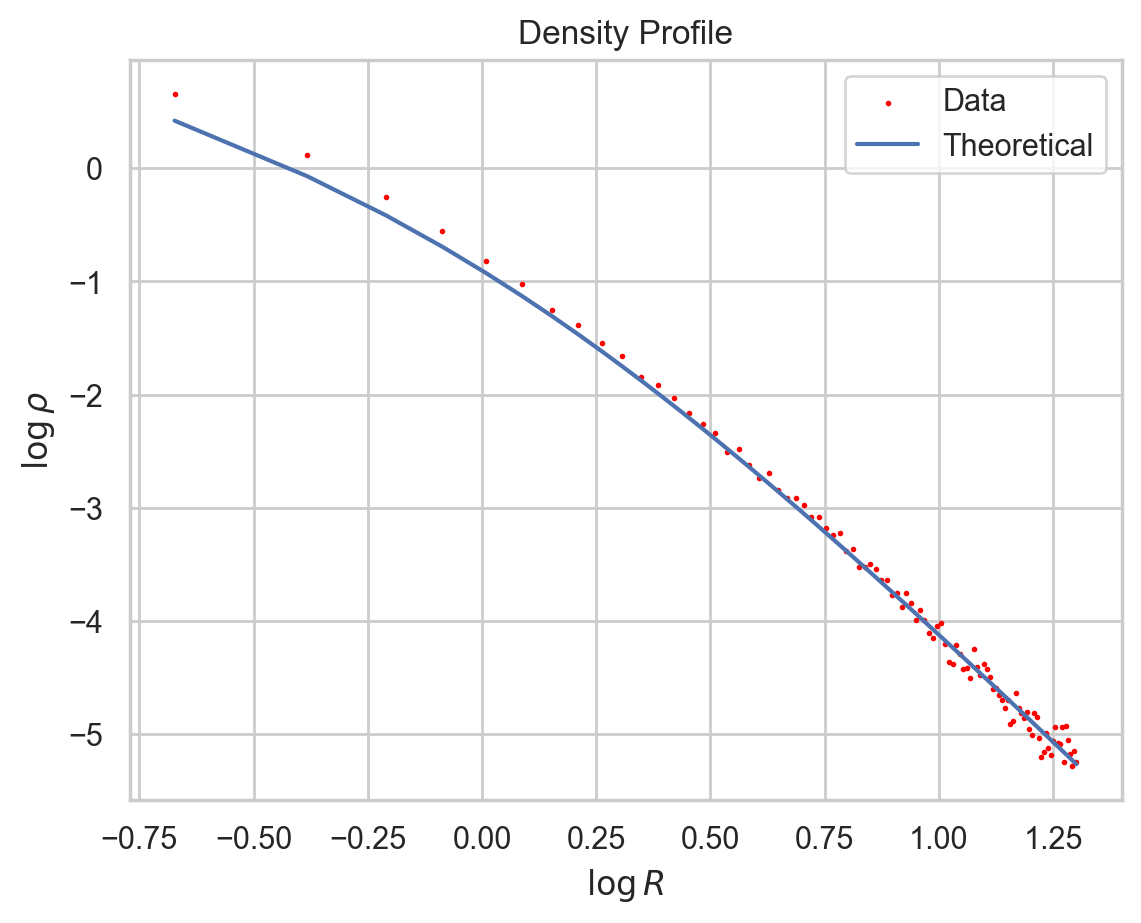

In [11]:
shell_r  = np.linspace(np.min(radii), 20*Rs, 100)
num_part = []
volume   = []

for i in range(1, len(shell_r)):
    count = sum(1 for r in radii if r > shell_r[i-1] and r < shell_r[i])
    volume.append(4/3 * np.pi * (shell_r[i]**3 - shell_r[i-1]**3))
    num_part.append(count)
    
num_part = np.array(num_part)
volume = np.array(volume)

rho_check = m * num_part / volume

# I remove the first element (I have 100 radii, which means that I have 99 shells and densities)
shell_r = shell_r[1:]

# I compute the theorical density with the radius of the shells and following equation 1
rho_th = H_profile(shell_r, Rs, rho_0)


########################################################################################################à

plt.scatter(np.log10(shell_r), np.log10(rho_check/rho_0), label='Data', color='red', s=1)
plt.plot(np.log10(shell_r), np.log10(rho_th/rho_0), label='Theoretical')
plt.legend()
plt.xlabel(r'$\log{R}$')
plt.ylabel(r'$\log{\rho}$')
plt.title('Density Profile')

### Hernquist Potential

The potential of a Hernquist distribution is defined as:

$$
    \Phi(r) =-  4 \pi G \rho_0 Rs^2 \frac{1}{2(1+ \frac{r}{Rs})}.
$$

Text(0, 0.5, '$\\Phi_H(r)$')

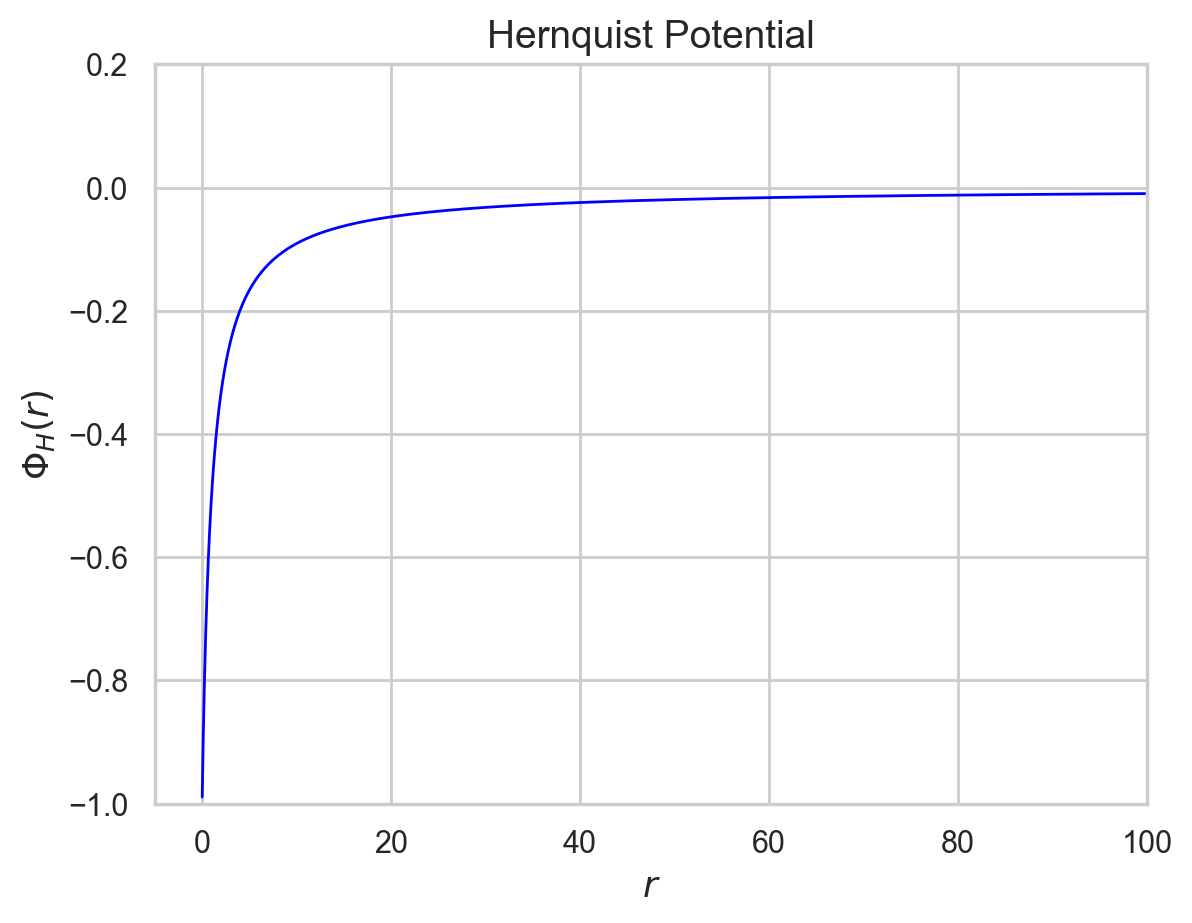

In [12]:
def H_pot(radii, Rs, rho_0):
    return - 2 * np.pi * rho_0 * Rs**3 / (Rs + radii)

###############################################################

Psi = H_pot(radii, Rs, rho_0) 

sns.set(style="whitegrid")
plt.plot(np.sort(radii), np.sort(Psi), color='blue', linewidth=1.0)
plt.title('Hernquist Potential', fontsize=14)
plt.xlabel(r'$r$', fontsize=13)
plt.xlim(-5, 100)
plt.ylim(-1, 0.2)
plt.ylabel(r'$\Phi_H(r)$', fontsize=13)

### Distribution Function
The distribution function in function of $\epsilon$ is:

$$
    f_H(\epsilon)=\frac{1}{\sqrt{2}(2 \pi)^3 (GM R_s)^{\frac{3}{2} }  } \frac{\sqrt{\epsilon}}{(1- \epsilon)^2} \left[ (1-2\epsilon) (8\epsilon ^2 - 8 \epsilon -3) + \frac{3 sin^{-1} \sqrt{\epsilon}}{\sqrt{\epsilon (1 - \epsilon)}}    \right] \tag{10},
$$
where $\epsilon = -\frac{E R_s}{GM}$.

In [13]:
# df in function of epsilon

def df_eps(E, Rs, M):
    epsilon = (E*Rs)/M
    term1 = 1 / ( np.sqrt(2) * ((2 * np.pi)**3) * (( M * Rs)**(3/2)) )
    term2 = np.sqrt(epsilon) / ((1 - epsilon)**2)
    term3 = (1 - 2 * epsilon) * ((8 * (epsilon**2)) - (8 * epsilon) - 3)
    term4 = (3 * (np.arcsin(np.sqrt(epsilon)) )  ) / (np.sqrt(epsilon * (1 - epsilon)))
    result = term1 * term2 * (term3 + term4)
    
    return result



# df in function of q
def df_q(q, Psi, Rs, M):
    
    epsilon = -Psi * (1-q**2)
    
    term1 = 1 / ( np.sqrt(2) * ((2* np.pi)**3) * ((M * Rs)**(3/2)) )
    term2 = np.sqrt(epsilon) / ((1 - epsilon)**2)
    term3 = (1 - 2 * epsilon) * ((8 * (epsilon**2)) - (8 * epsilon) - 3)
    term4 = (3 * (np.arcsin(np.sqrt(epsilon)) )  ) / (np.sqrt(epsilon * (1 - epsilon)))
    result = term1 * term2 * (term3 + term4)
    
    return result    

(-0.1, 1.5)

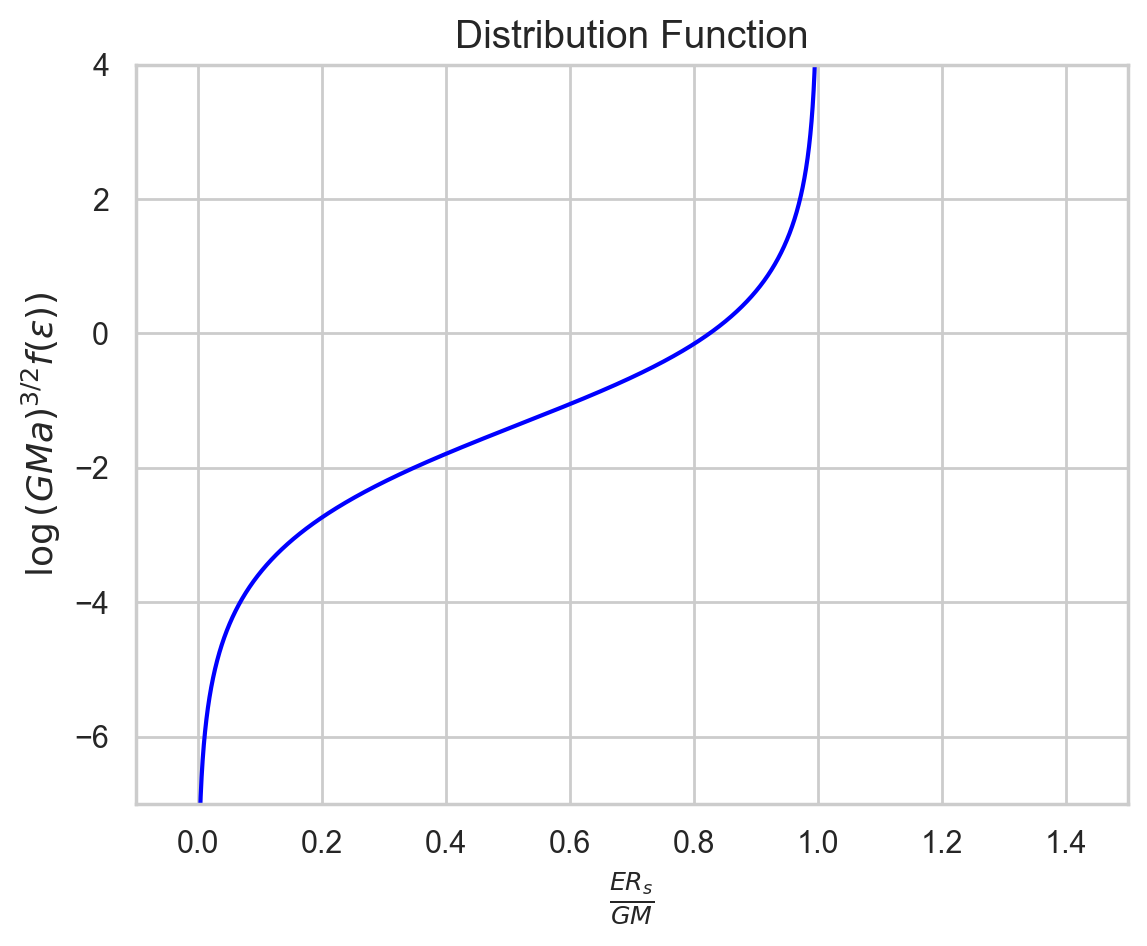

In [14]:
# I plot the distribution function in the same way it is plotted on the book to check if it is correct

asse_x = np.linspace(0.001, 0.999, N) 

E       = asse_x * (M/Rs)
epsilon = (E*Rs)/(M)
df      = df_eps(epsilon, Rs, M)

asse_y = np.log10(((M*Rs)**(3/2)) * df)

sns.set(style="whitegrid")


plt.plot(E, asse_y, color='blue')
plt.title(r'Distribution Function', fontsize=14)
plt.xlabel(r'$\frac{ER_s}{GM}$', fontsize=13)
plt.ylabel(r'$\log{(GMa)^{3/2} f(\varepsilon))}$', fontsize=13)

plt.ylim(-7,4)
plt.xlim(-0.1,1.5)

<img src="immagini/immagine.png" alt="Figure on the book" width="590">

### Velocities sampling with MC rejection method
I use the Monte Carlo rejection method to sample the escape velocity ratio $q = \frac{v}{v_{esc}}$, from which I can then find $v$.
I use the integral of the distribution function $f(\epsilon)$ expressing it in function of $q$:

$$ F(\varepsilon) = \int_0^{\varepsilon} f(\varepsilon) d^3 v = \int_0^{\varepsilon} f(\varepsilon)  4 \pi v^2 dv \propto  \int_0^1 f\left(-\Psi (1-q^2)\right)  4 \pi (- 2 \Psi q^2)  \sqrt{- 2 \Psi} dq.
$$

In [15]:
def F(df, q, psi):
    return df * 4 * np.pi * (- 2 * psi * q**2) * np.sqrt(- 2 * psi)

In [16]:
# MC rejection method 

qs = []

for psi in tqdm(Psi):
    q = random.uniform(0.0001,0.9999)
    
    func = F(df_q(q, psi, Rs, M), q, psi)
    func_max = np.max(func)
    
    y_rand = random.uniform(0, func_max)
    
    while(y_rand > F(df_q(q, psi, Rs, M), q, psi)):
        
        q = random.uniform(0.001, 0.999)
          
        func = F(df_q(q, psi, Rs, M), q, psi)
        func_max = np.max(func)
    
        y_rand = random.uniform(0, func_max)
    qs.append(q)
          
qs = np.array(qs)

100%|██████████| 10000/10000 [00:00<00:00, 14587.91it/s]


Now I compute the velocities as:
$$
    v = q \cdot v_{escape},
$$
where $v_{escape}= \sqrt{2\Psi}$.

In [17]:
v = qs * np.sqrt(-2* Psi) # Psi in negative

vel_theta_cdf = np.random.uniform(0, 1, N)
vel_theta = np.arccos(1 - 2 * vel_theta_cdf)

vel_phi = np.random.uniform(0, 2*np.pi, size=N)

In [18]:
# I trasform the velocities in cartesian coordinates
v_x = v * np.sin(vel_theta) * np.cos(vel_phi)
v_y = v * np.sin(vel_theta) * np.sin(vel_phi)
v_z = v * np.cos(vel_theta)

Text(0.5, 1.0, 'Velocities distribution')

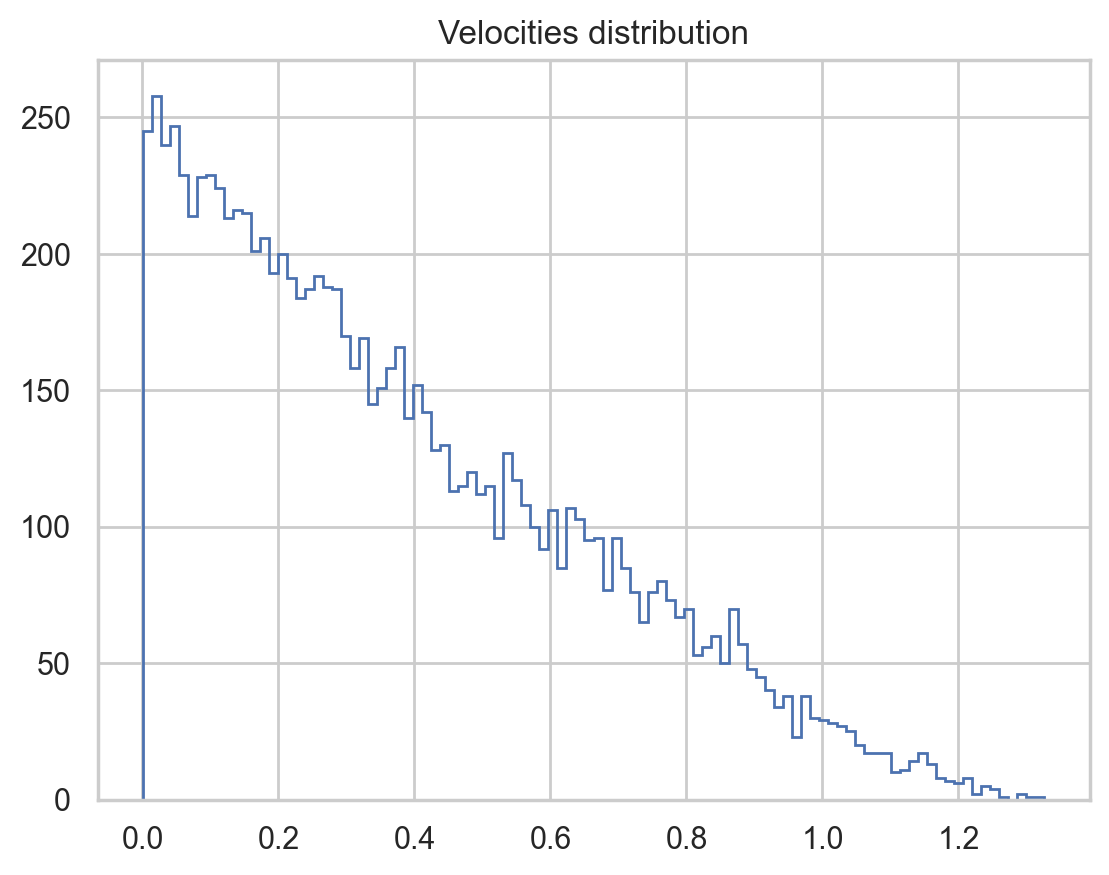

In [19]:
plt.hist(v, bins=100, histtype='step')
plt.title('Velocities distribution')

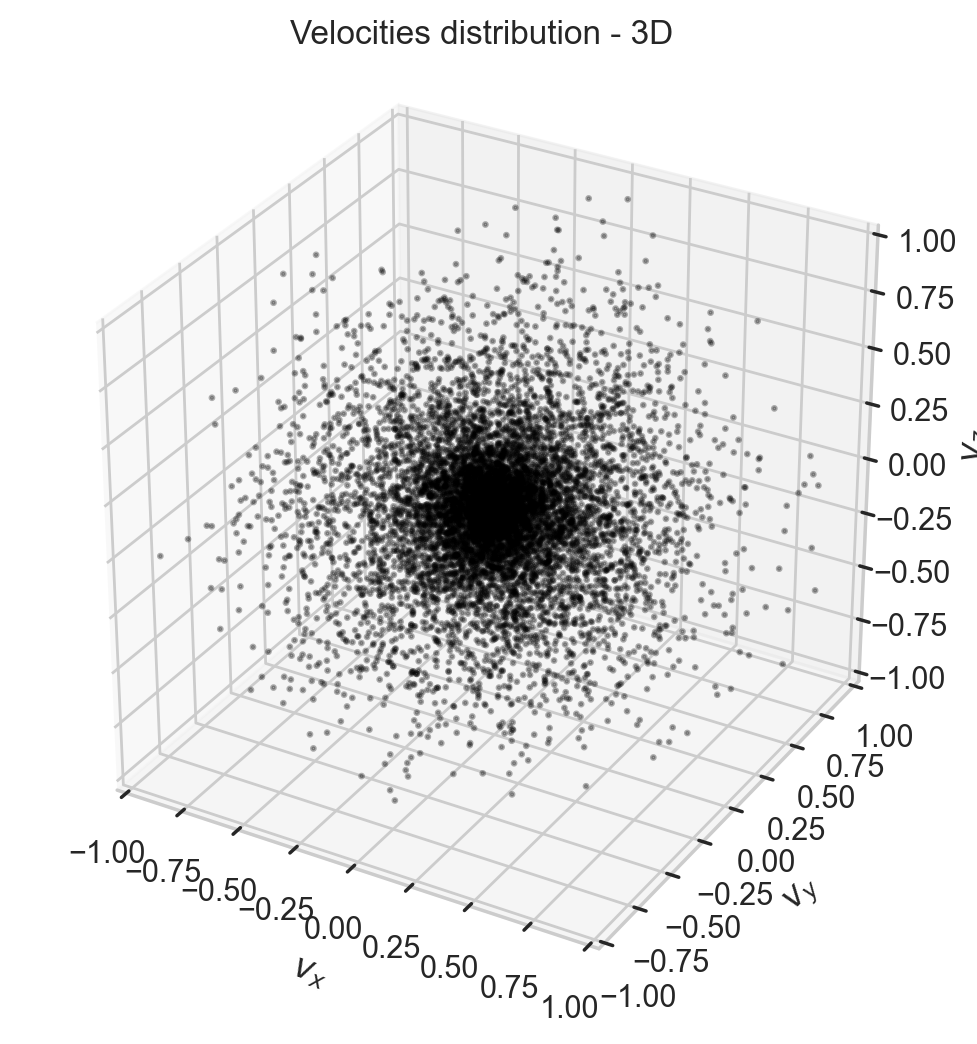

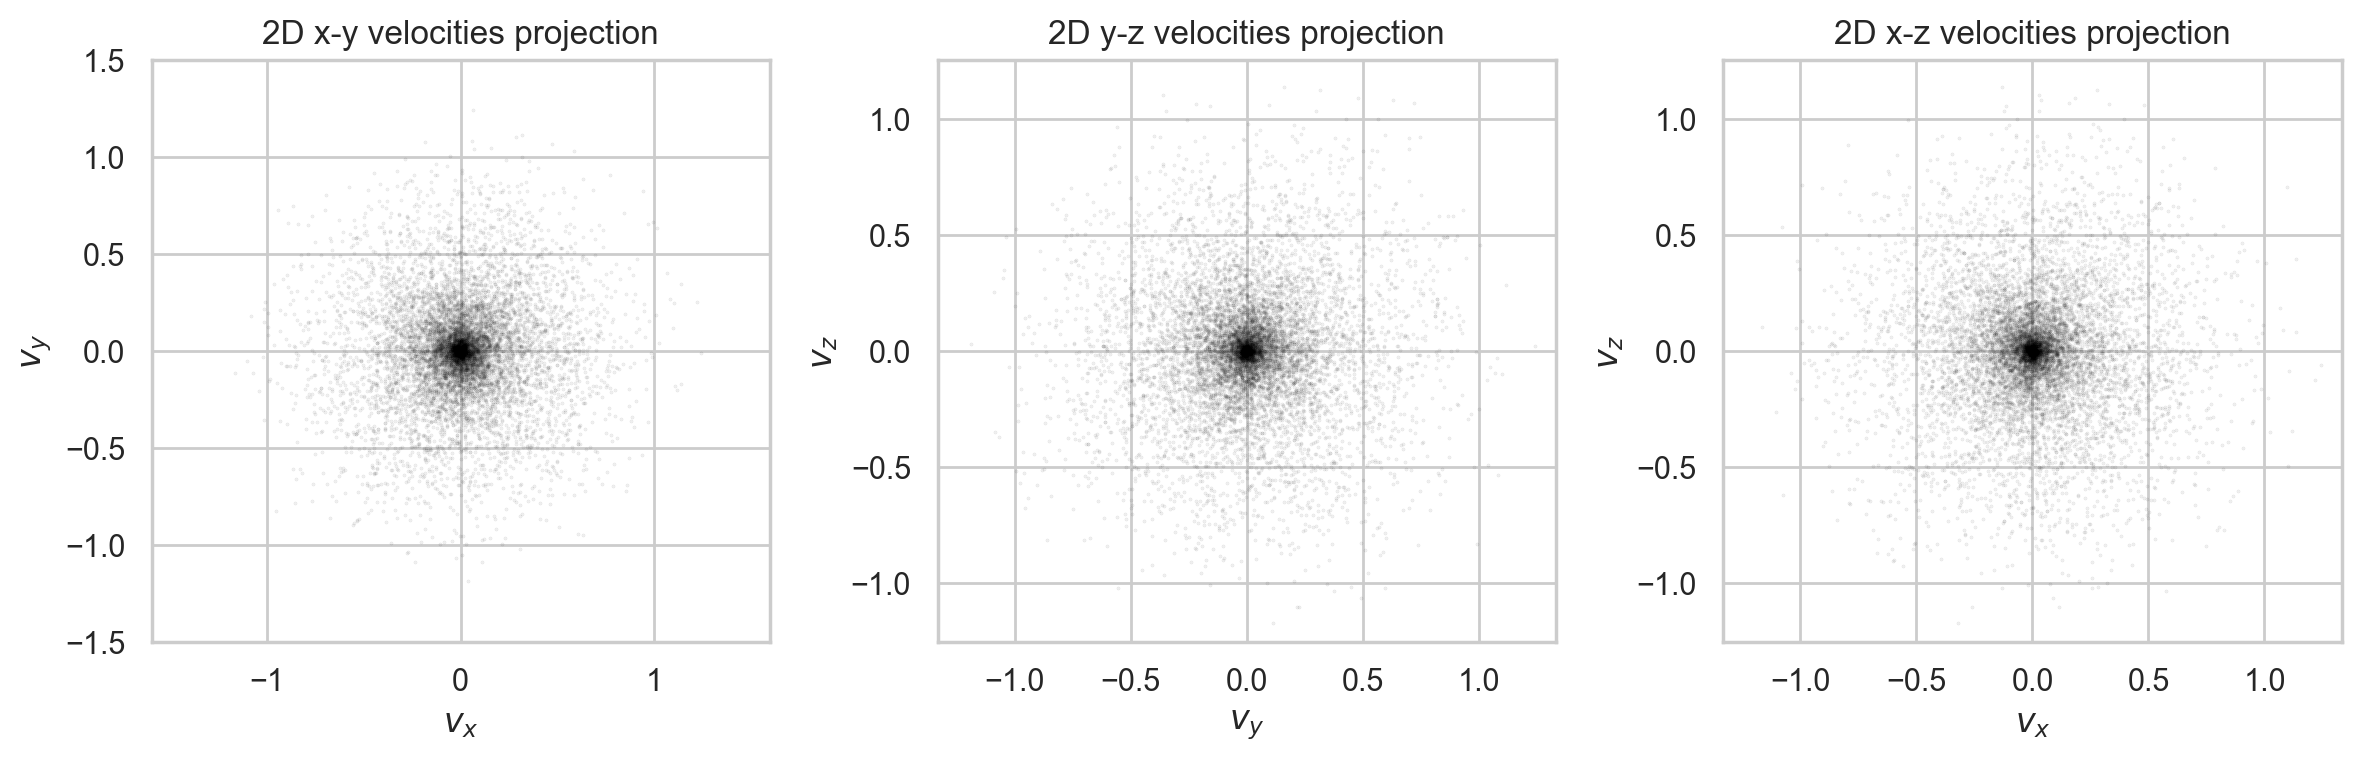

In [20]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(v_x, v_y, v_z, c = 'black', s=2, alpha=0.3)
ax.set_box_aspect([1,1,1])
ax.set_aspect('equal')
ax.set_xlabel(r'$v_x$')
ax.set_ylabel(r'$v_y$')
ax.set_zlabel(r'$v_z$')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_title("Velocities distribution - 3D")
plt.show();

##########################################################################à
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

#Projection on x-y plane
theta = np.linspace(0, 2 * np.pi, 150)

axes[0].scatter(v_x, v_y, c='black', s=0.1, alpha=0.1)
#axes[0].plot(a, c, c='red', label=r'$v_{esc}$', linewidth=4)
axes[0].axis('equal')
axes[0].set_xlim(-1.5, 1.5)
axes[0].set_ylim(-1.5, 1.5)
axes[0].set_xlabel(r'$v_x$')
axes[0].set_ylabel(r'$v_y$')
axes[0].set_title('2D x-y velocities projection')


# Projection on y-z plane
axes[1].scatter(v_y, v_z, c='black', s=0.1, alpha=0.1)
axes[1].axis('equal')
axes[1].set_xlim(-1.5, 1.5)
axes[1].set_ylim(-1.5, 1.5)
axes[1].set_xlabel(r'$v_y$')
axes[1].set_ylabel(r'$v_z$')
axes[1].set_title('2D y-z velocities projection')



# Projection on x-z plane
axes[2].scatter(v_x, v_z, c='black', s=0.1, alpha=0.1)
axes[2].axis('equal')
axes[2].set_xlim(-1.5, 1.5)
axes[2].set_ylim(-1.5, 1.5)
axes[2].set_xlabel(r'$v_x$')
axes[2].set_ylabel(r'$v_z$')
axes[2].set_title('2D x-z velocities projection')


plt.tight_layout()
plt.show()

Now I run a little test to check that the velocities are smaller than the escape velocity.

In [21]:
v_esc =  np.sqrt(-2* np.sort(Psi))

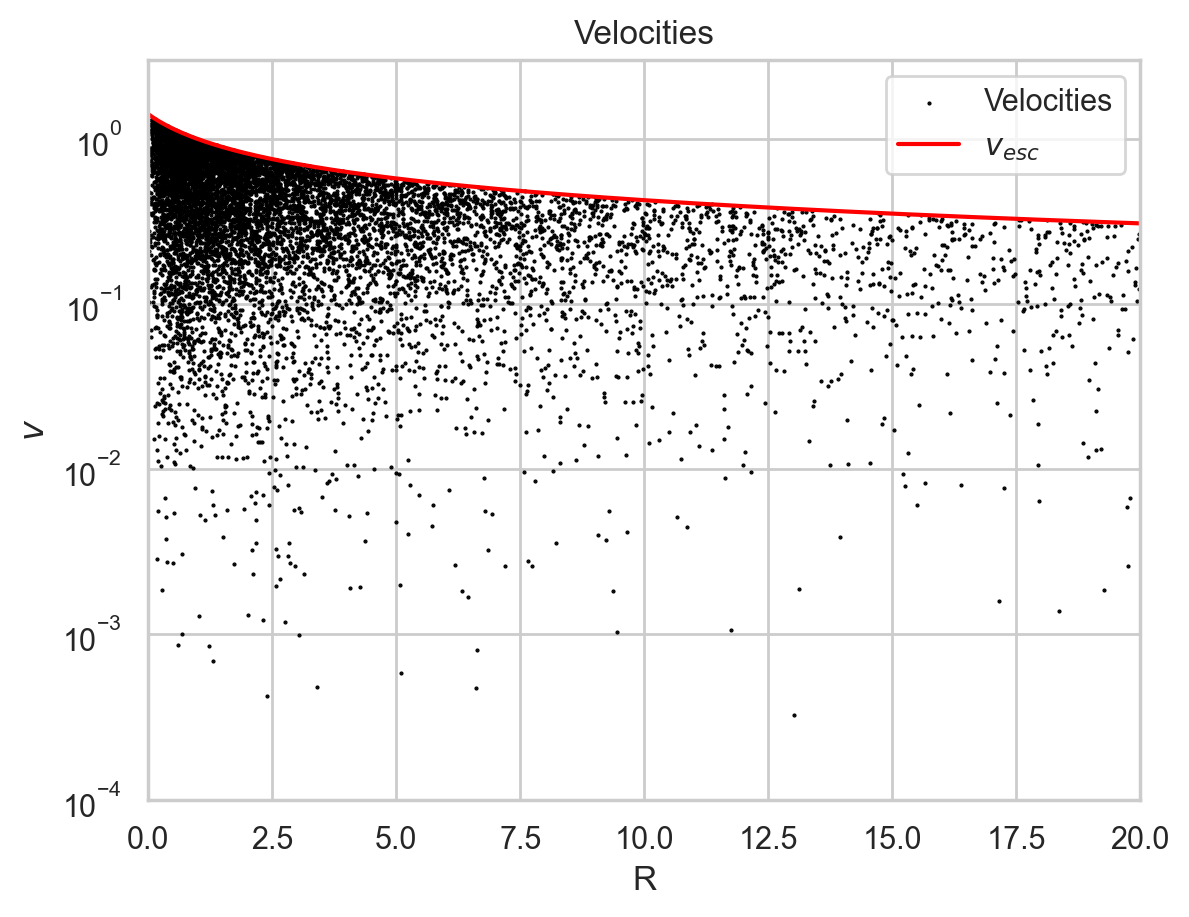

In [22]:
plt.scatter(radii, v, marker='.', s=1, color='black', label='Velocities')
plt.plot(np.sort(radii), v_esc, color='red', label=r'$v_{esc}$')
plt.xlabel('R')
plt.ylabel(r'$v$')
plt.xlim(0, 20)
plt.ylim(1e-4,3)
plt.yscale('log')
plt.title('Velocities')
plt.legend()

### Initial conditions

In [23]:
# creating the input file
m_arr = m * np.ones(N)
dim = 3


with open ('in_H.txt', 'w+') as f:
    f.write(str(N) + '\n')
    f.write(f'{dim}' + '\n')
    f.write('0' + '\n')
    for m_i in m_arr:
        f.write(f'{m_i}' + '\n')
    for i in range(N):
        f.write(f'{x[i]} {y[i]} {z[i]}' + '\n')
    for j in range(N):
        f.write(f'{v_x[j]} {v_y[j]} {v_z[j]}' + '\n')

In [24]:
T_dyn = (3*np.pi/(16*rho_0))**(1/2)
print("Dynamical Time: ", T_dyn)

V = 4/3 * np.pi * Rs**3
epsilon = round(1/10 * (V/N)**(1/3), 4)
print("Epsilon: ", epsilon)

T_sim = np.round(10 * T_dyn)
print("Simulation time: ", T_sim)

dt = 1/200
theta = 0.2
t_out = dt*100


Dynamical Time:  1.9238247452427961
Epsilon:  0.0075
Simulation time:  19.0


In [25]:
print('time ./treecode in=in_H.txt dtime='+ str(dt) + ' eps='+str(epsilon)+' theta='+str(theta)+ ' tstop='+str(T_sim) +' dtout='+str(t_out)+  ' out=out_H.txt >logout_H.txt')

time ./treecode in=in_H.txt dtime=0.005 eps=0.0075 theta=0.2 tstop=19.0 dtout=0.5 out=out_H.txt >logout_H.txt


The simulation took 47 minutes and 9 seconds

# ANALYSIS

In [26]:
# reading the data 

lines = pd.read_csv('out_H.txt', names = list(range(3)), sep = '\s+')
N_particles = N
s = N*3+3


t_s  = np.array([lines.iloc[2::s,0].copy().dropna()]).flatten()


# particles 
m_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(3, N+3)])
x_s  = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(N+3, 2*N+3)])
y_s  = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(N+3, 2*N+3)])
z_s  = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(N+3, 2*N+3)])
vx_s = np.array([lines.iloc[i::s,0].copy().dropna() for i in range(2*N+3, 3*N+3)])
vy_s = np.array([lines.iloc[i::s,1].copy().dropna() for i in range(2*N+3, 3*N+3)])
vz_s = np.array([lines.iloc[i::s,2].copy().dropna() for i in range(2*N+3, 3*N+3)])


# radii
r_s = np.sqrt(x_s**2 + y_s**2 + z_s**2)

### Center of mass
I do not take into account the particles which have a radius at the final time over 20. Doing this, I eliminate particles which are too far away (9.2% of the particles).

In [27]:
mu = m / M

x_cm_s = mu * np.sum(x_s[np.where(r_s[:,-1]<20)], axis = 0)
y_cm_s = mu * np.sum(y_s[np.where(r_s[:,-1]<20)], axis = 0)
z_cm_s = mu * np.sum(z_s[np.where(r_s[:,-1]<20)], axis = 0)
r_cm_s = np.sqrt(x_cm_s**2 + y_cm_s**2 + z_cm_s**2)


conteggio = np.sum(r_s[:,-1] > 20)
(conteggio / N)*100

8.84

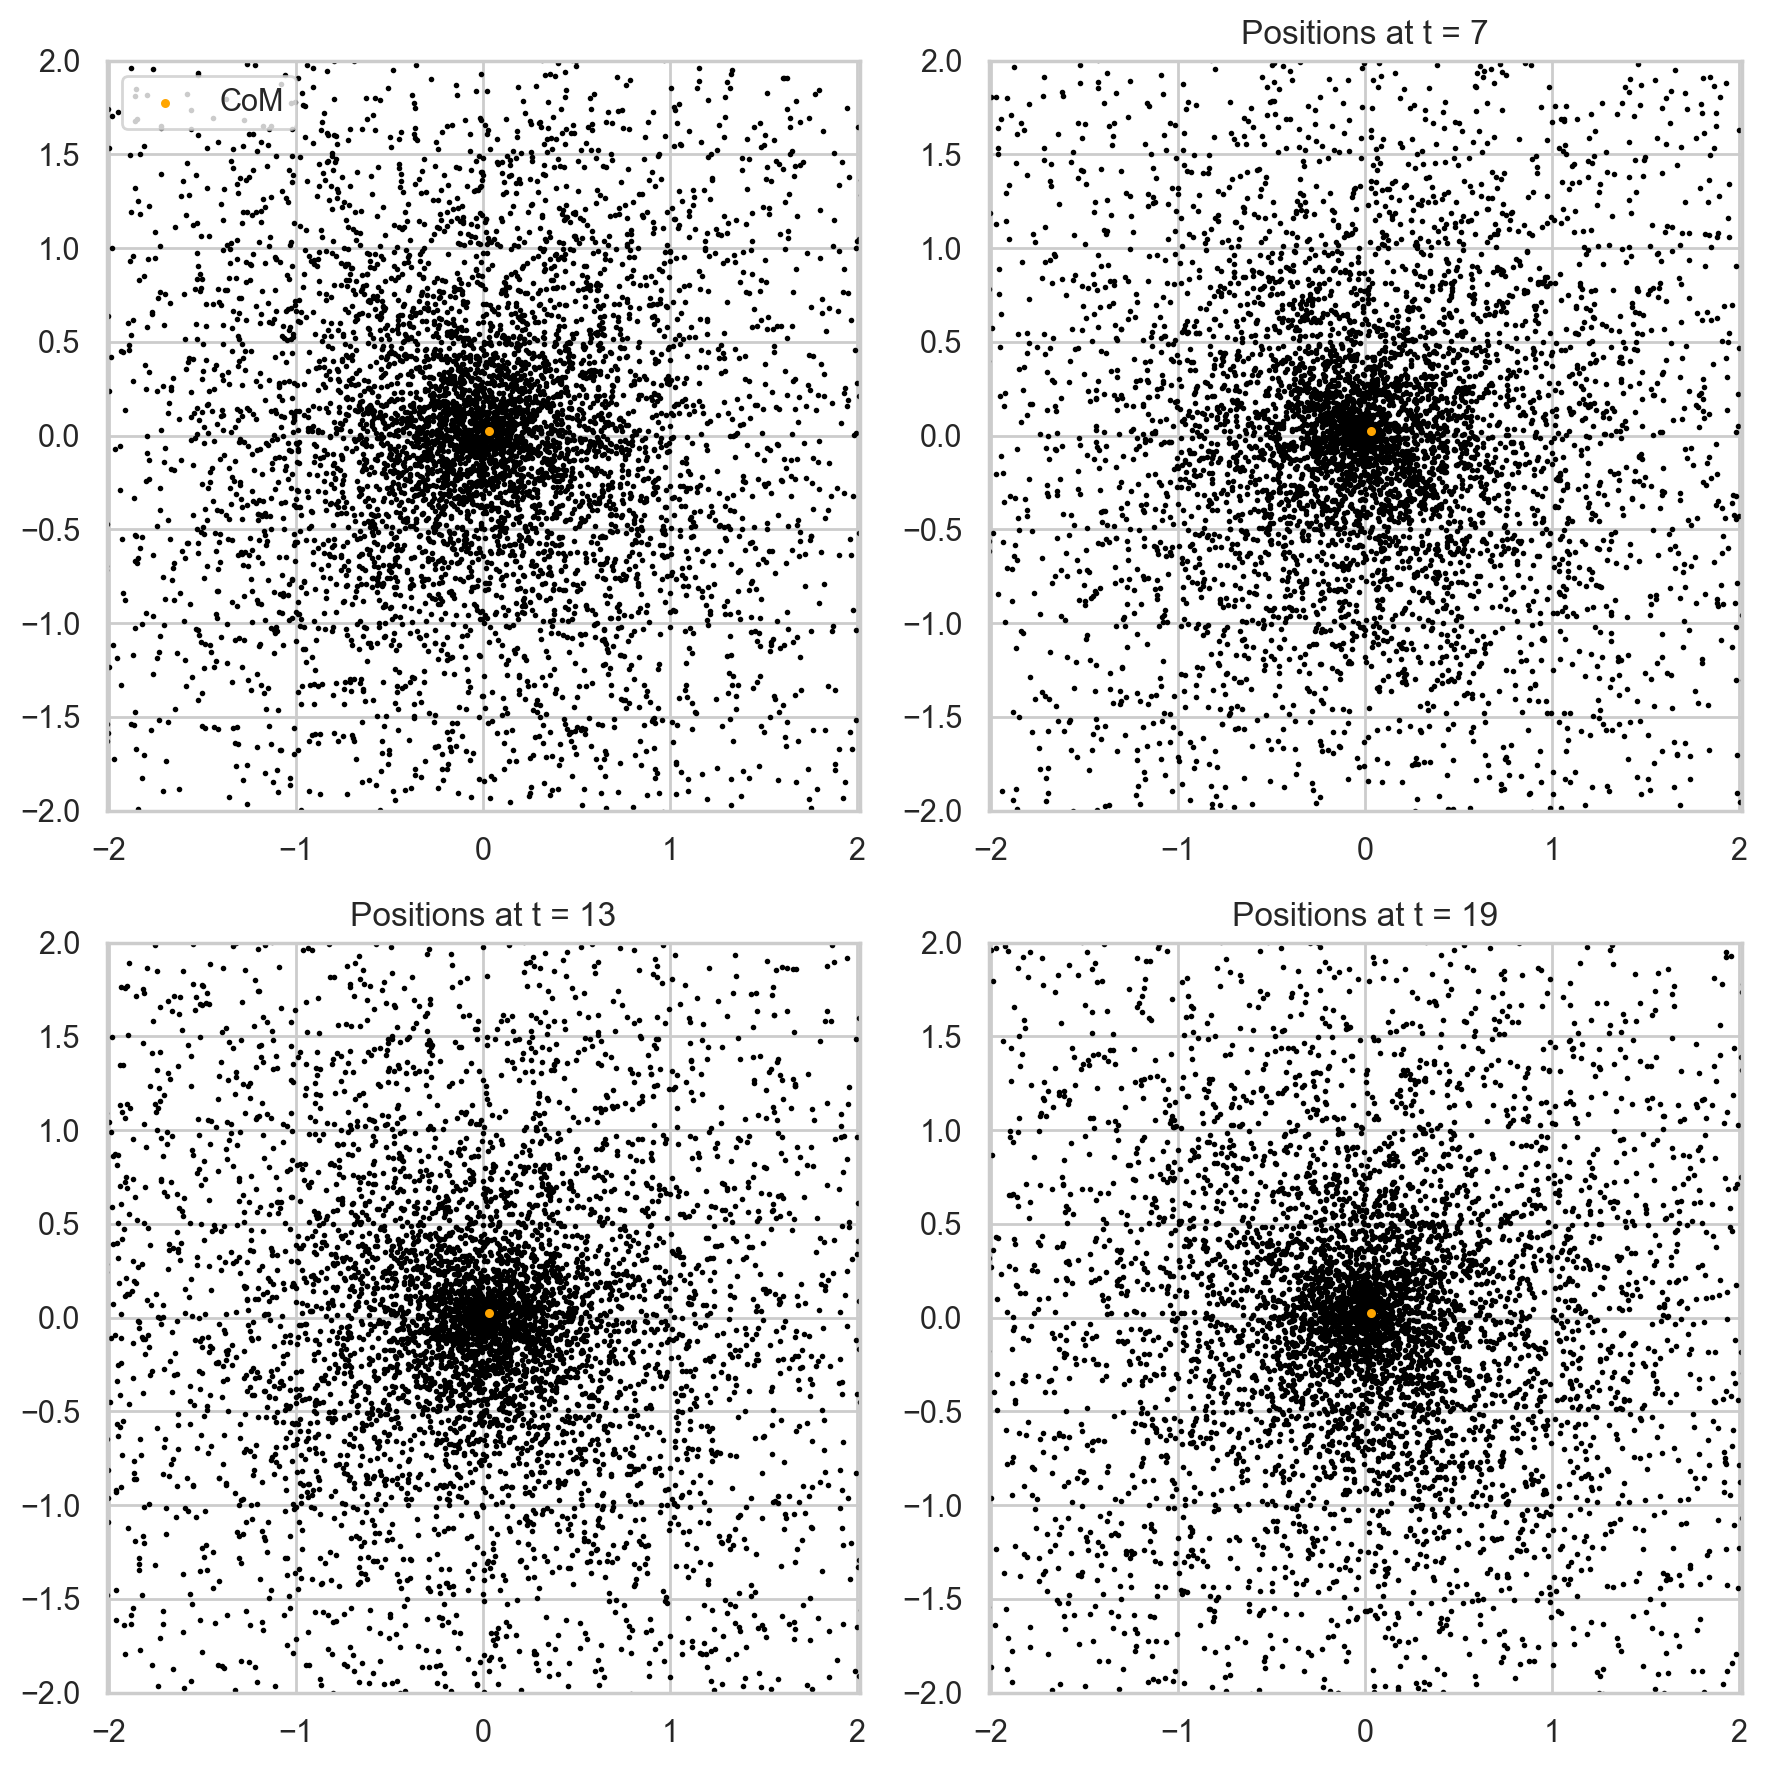

In [28]:
# showing how the distribution evolves at 4 different times just to have an idea of how it behaves 

t0 = 0
t1 = int(np.round(len(t_s) * 1 / 3))
t2 = int(np.round(len(t_s) * 2 / 3))
t3 = -1


sns.set(style="whitegrid")
fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(9, 9)) 

# Plot 1
ax[0][0].scatter(x_s[:, t0], y_s[:, t0], c='black', alpha=1, s=1)
ax[0][0].scatter(x_cm_s[t0], y_cm_s[t0], c='orange', alpha=1, s=5, label='CoM')
#ax[0][0].set_title(f'Positions at t = {int(np.round(2t_s[t0]))}')
ax[0][0].axis('equal')
ax[0][0].set_xlim(-2, 2)
ax[0][0].set_ylim(-2, 2)
ax[0][0].legend()


# Plot 2
ax[0][1].scatter(x_s[:, t1], y_s[:, t1], c='black', alpha=1, s=1)
ax[0][1].scatter(x_cm_s[t0], y_cm_s[t0], c='orange', alpha=1, s=5)
ax[0][1].set_title(f'Positions at t = {int(np.round(t_s[t1]))}')
ax[0][1].axis('equal')
ax[0][1].set_xlim(-2, 2)
ax[0][1].set_ylim(-2, 2)


# Plot 3
ax[1][0].scatter(x_s[:, t2], y_s[:, t2], c='black', alpha=1, s=1)
ax[1][0].scatter(x_cm_s[t0], y_cm_s[t0], c='orange', alpha=1, s=5)
ax[1][0].set_title(f'Positions at t = {int(np.round(t_s[t2]))}')
ax[1][0].axis('equal')
ax[1][0].set_xlim(-2, 2)
ax[1][0].set_ylim(-2, 2)

# Plot 4
ax[1][1].scatter(x_s[:, t3], y_s[:, t3], color='black', alpha=1, s=1)
ax[1][1].scatter(x_cm_s[t0], y_cm_s[t0], c='orange', alpha=1, s=5)
ax[1][1].set_title(f'Positions at t = {int(np.round(t_s[t3]))}')
ax[1][1].axis('equal')
ax[1][1].set_xlim(-2, 2)
ax[1][1].set_ylim(-2, 2)


plt.show()

  0%|          | 0/38 [00:00<?, ?it/s]

MovieWriter ffmpeg unavailable; using Pillow instead.


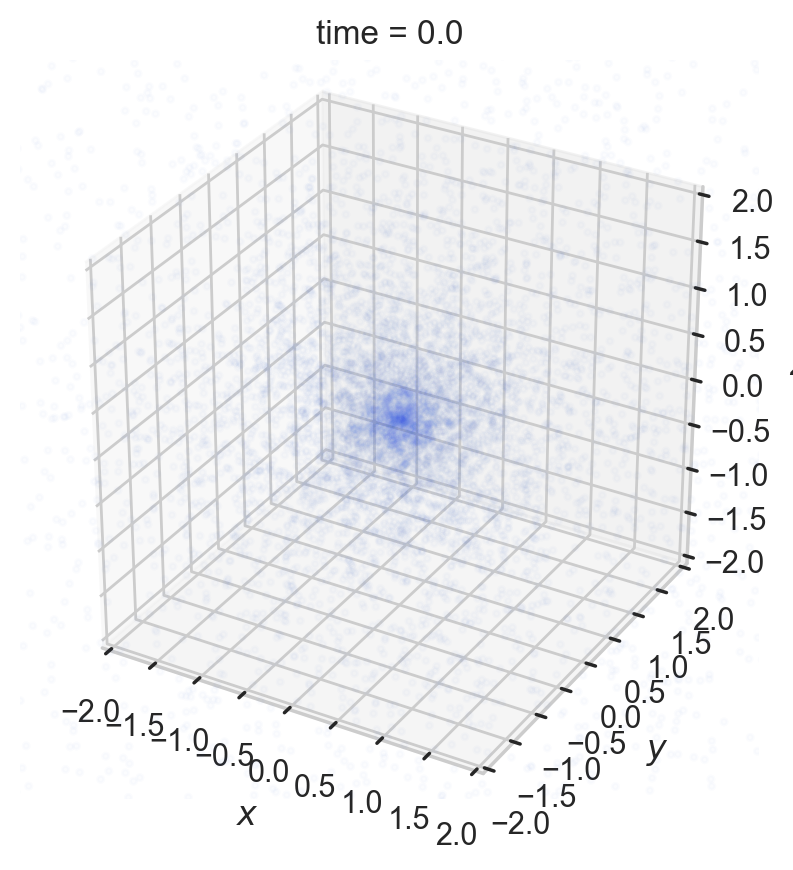

In [29]:
# ANIMATION

from matplotlib import animation
from tqdm.notebook import tqdm
from IPython.display import HTML
import matplotlib.pyplot as plt

plt.rcParams['animation.embed_limit'] = 100.0  

def update(num):
    global N    #N_particles
    l = 2
    ax.clear()
    
    ax.scatter(x_s[:,num], y_s[:,num], z_s[:,num], color = 'royalblue', s = 5 ,alpha = .02)        
    
    ax.set_title(f'time = {round(t_s[num],1)}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$z$')
    
    ax.set_xlim(-l, l)
    ax.set_ylim(-l, l)
    ax.set_zlim(-l, l)
    

## Plotting the Animation
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set(aspect='equal')
line_ani = animation.FuncAnimation(fig, update, interval=130,   
                                   frames=tqdm(range(len(t_s) - 1)));

HTML(line_ani.to_jshtml())
line_ani.save(f'Hernquist.gif')

It is possible to look at the animation at the beginning of the notebook.

### Lagrangian radii
I compute the lagrangian radii with respect to the center of mass and I compare them to the theoretical ones found from equation 5 replacing P with the quantile.

  0%|          | 0/5 [00:00<?, ?it/s]

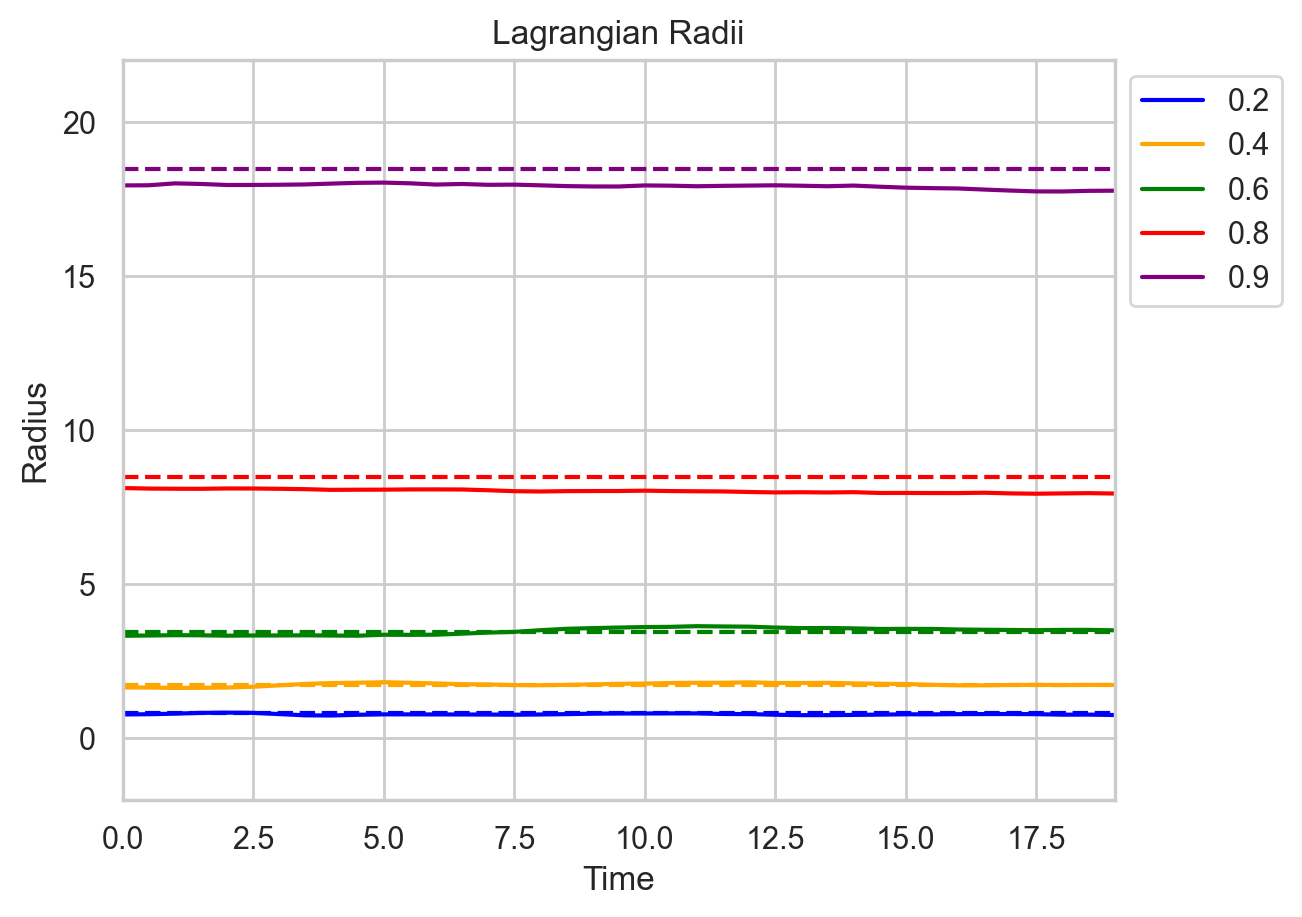

In [30]:
quantiles = [0.2,0.4,0.6, 0.8, 0.9]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'cyan', 'pink', 'grey']

for q, c in tqdm(zip(quantiles, colors), total=len(quantiles)):
    
    L_radii = []
    
    for i in range(len(t_s)):
        a    = np.sort(r_s[:,i]-r_cm_s[i])
        mask = a<np.quantile(a,q)
        L_radii.append(np.max(a[mask]))
    
    L_radii = np.array(L_radii)
    L_th =(Rs*np.sqrt(q))/(1 - np.sqrt(q))
    
    plt.plot(t_s,L_radii, color=c, label=str(q))
    plt.axhline(y = L_th, color=c, linestyle='--')

plt.ylim(-2,22)
plt.xlim(0, np.max(t_s))
plt.xlabel('Time')
plt.ylabel('Radius')
plt.title('Lagrangian Radii')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

The Lagrangian Radii (solid lines) are very similar to the theoretical ones (dashed lines) and they remain almost constant during the evolution in time of the system, suggesting that the system is stable.

### Distribution check
I check the radii distribution to see how it evolves in time. Despite some minor fluctuations, the overall pattern of the distribution remains consistent, indicating the stability of the system.

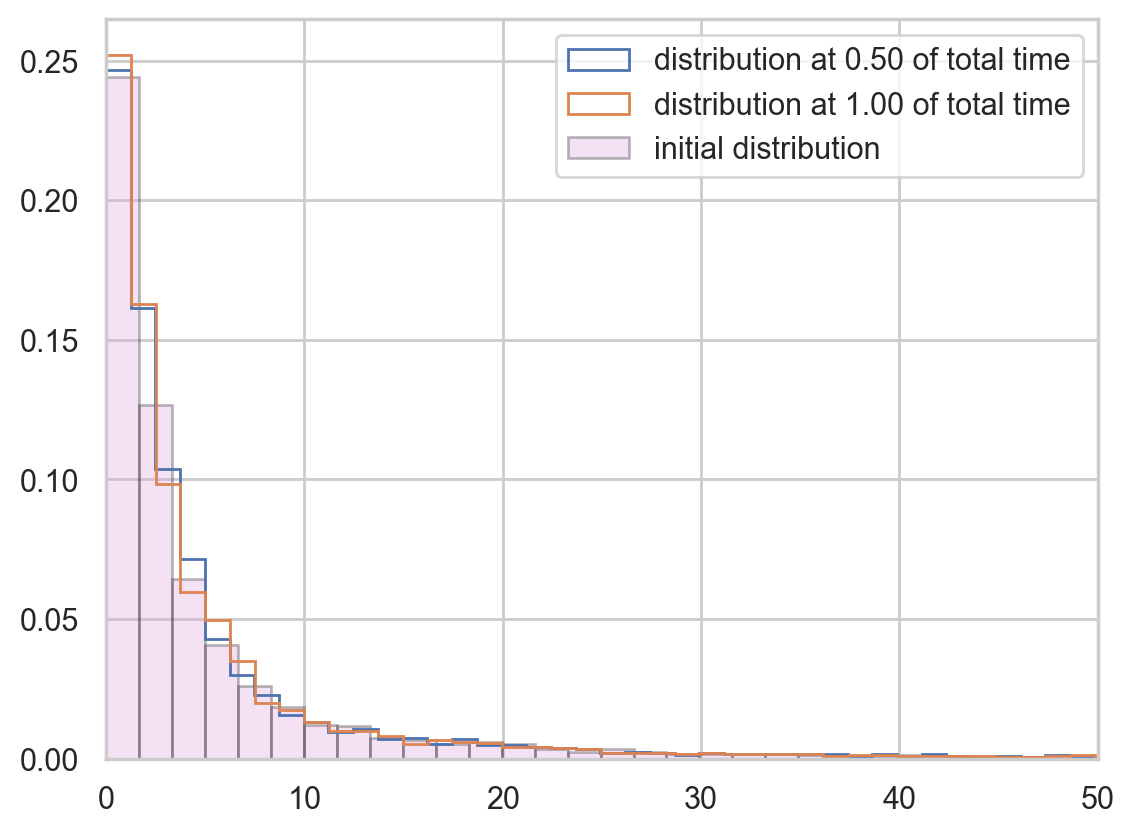

In [31]:
def distribution(frac):
    t = int(len(t_s)*frac)
    r_t = r_s[:,t-1]
    plt.hist(r_t[r_t<50], bins=40, density=True, histtype='step', label='distribution at %.2f of total time' %frac)


f=[0.5,1]
for frac in f:
    distribution(frac)
    
plt.hist(radii[radii<50], bins=30, density=True, alpha=0.3, color='plum', ec='k', histtype='bar', label='initial distribution');
plt.xlim(0,50)
plt.legend();

### Energy Analysis
I plot the kinetic, potential and total energies to observe their evolution in time and to check if the total energy remains stable.

In [32]:
# reading the output file
energy = pd.read_csv('logout_H.txt', header=None).to_numpy()

good_rows = [i+1 for i, row in enumerate(energy) if '        time' in row[0]]

good_data = [energy[index] for index in good_rows] 
good_data = np.array(good_data)

In [33]:
time_energy = []
T   = []
U   = []

for i in range (0, len(good_data)):
    time_energy.append(float(good_data[i][0][6:12]))
    T.append(float(good_data[i][0][21:28]))
    U.append(float(good_data[i][0][30:36]))
                    
time_energy = np.array(time_energy)
T = np.array(T)
U = -np.array(U)
E_tot = T + U

mean_E   = np.average(E_tot)
E_stdev  = np.std(E_tot)

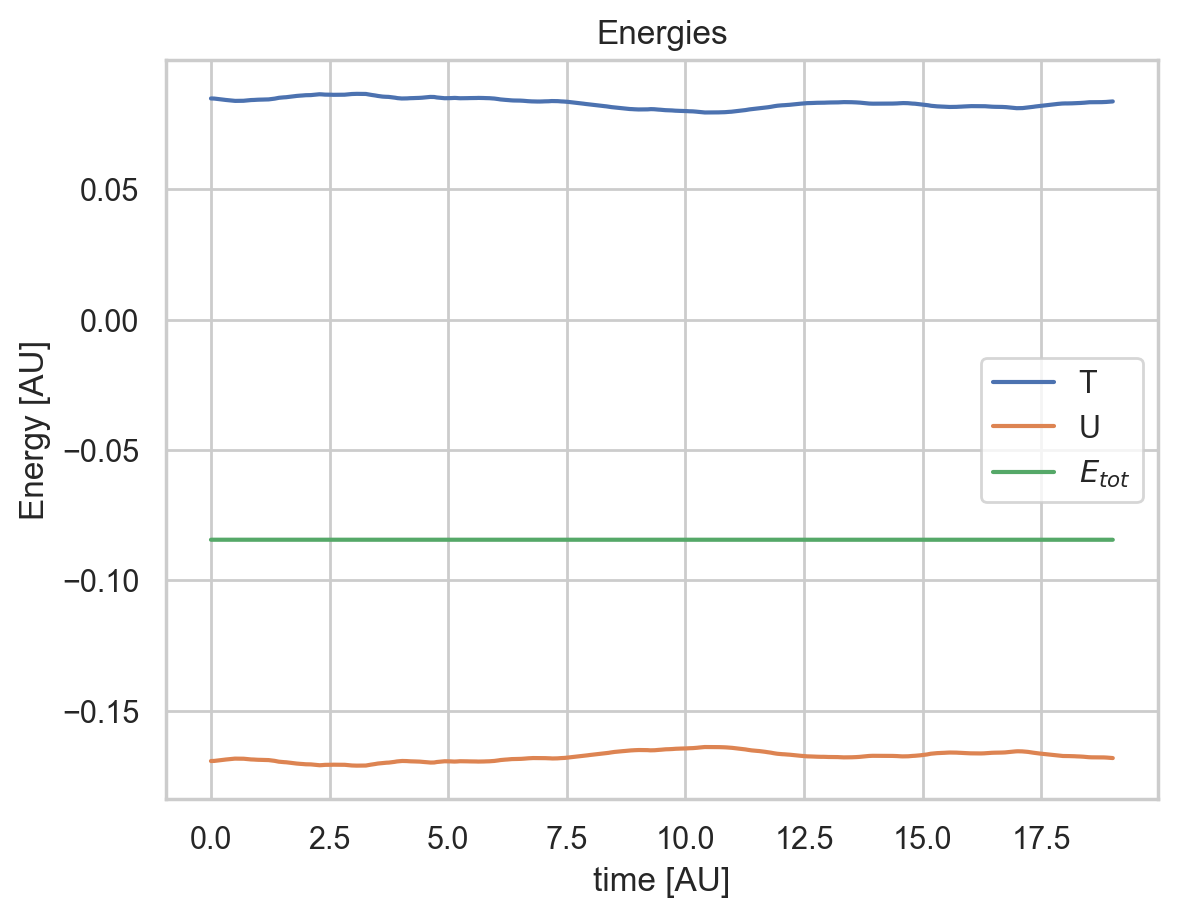

In [34]:
plt.plot(time_energy, T, label='T')
plt.plot(time_energy, U, label='U')
plt.plot(time_energy, E_tot, label=r'$E_{tot}$')

plt.xlabel('time [AU]')
plt.ylabel('Energy [AU]')
plt.title('Energies')
plt.legend()
plt.show()


In [35]:
# relative error on total energy
rel_err = abs(E_stdev/mean_E)*100
print(f'Relative error: {rel_err:.2f} %')

Relative error: 0.01 %


The total energy remains stable during the evolution in time of the system, meaning that the total energy is conserved, as expected.

# Physical Units
I convert the main variables from internal units to physical units assuming the Milky Way as a model.

**Internal Units:**
- $M = 1$, total mass of the distribution
- $m = 0.0001$, mass of the particles

- $R_s = 1$, scale radius
- $\rho_0 = 0.159$, initial density
- $T_{dyn} = 1.924$, dynamical time
<br>

**Milky Way:**
- Mass = $10^{10} M_{\odot}$ 
- Radius = $2$ kpc

In [36]:
m_sun = 2e33      # g
G     = 6.673e-8  # cm^3 g^(-1) s^(-2)

mass_mw =  10**10 * m_sun  # g
r_mw    = 2 * (3.0857*10**21) # cm

In [37]:
# masses
m_distr     = M * mass_mw
m_particles = m_distr / N
m_pert_phy  = 0.05 * m_distr
print(f'Mass of the distribution = {m_distr:.3} g = {m_distr/m_sun:.3} M_sun.')
print(f"Mass of the single particle = {m_particles} g." )
print('\n')


# radius
scale_r = Rs * r_mw
print(f"Scale radius = {scale_r:.3} cm = {scale_r/(3.0857*10**21)} kpc.")
print('\n')


# density
rho0_phys = m_distr / (2 * np.pi * (scale_r)**3)
print(f"Initial density = {rho0_phys:.3} g/cm^3.")
print('\n')

# dynamical time
Tdyn_phys = (3*np.pi/(G*16*rho0_phys))**(1/2) 
Tdyn_phys_yr = Tdyn_phys * 3.17*10**(-8)
print(f"Dynamical time = {Tdyn_phys:.3} s = {Tdyn_phys_yr:.3} yr.")
print('\n')

# circular velocity at Rs
v_phys = np.sqrt((G * m_distr * Rs) / (M * scale_r))
print(f"Circular velocity at Rs = {v_phys:.3} cm/s.")

Mass of the distribution = 2e+43 g = 1e+10 M_sun.
Mass of the single particle = 2e+39 g.


Scale radius = 6.17e+21 cm = 2.0 kpc.


Initial density = 1.35e-23 g/cm^3.


Dynamical time = 8.07e+14 s = 2.56e+07 yr.


Circular velocity at Rs = 1.47e+07 cm/s.


# References
Joshua E. Barnes. _Treecode Guide_. https://home.ifa.hawaii.edu/users/barnes/treecode/treeguide.html. Accessed: 2024-05-28. 2024.

J. Binney and S. Tremaine. _Galactic Dynamics: Second Edition_. Princeton Series in Astrophysics. Princeton University Press, 2011. isbn: 781400828722. url: https://books.google.it/books?id=6mF4CKxlbLsC.